In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Merging two datasets into one master dataset. 

In [2]:
df1 = pd.read_csv('train_data.csv')
df2 = pd.read_csv('test_data.csv')
df = pd.concat([df1, df2])

In [3]:
df.head(10)

,Unnamed: 0,Sentence_id,New_Sentence,Type
0,0,GERRES15609,Author and/or Review architecture/design and o...,Responsibility
1,1,PHERES15784,Should be able to develop custom dynamic shape...,Responsibility
2,2,GERREQ10457,Experience in working crosslly with a larger ...,Requirement
3,3,GERSKL27235,"Previous business experience, including but no...",Skill
4,4,HONSSK18415,Delivering fast and right the first time.,SoftSkill
5,5,INDRES9494,Track department expenses and capital budget .,Responsibility
6,6,HONRES51852,Meet performance metrics.,Responsibility
7,7,UAEREQ34683,YOU MUST HAVEBachelors degree in Engineering.,Requirement
8,8,UAEREQ4612,After COVID-19: Ability to travel to manufactu...,Requirement
9,9,INDEDU42721,Six Sigma qualification to at least Green Bel...,Education


In [4]:
df.describe()

,Unnamed: 0
count,75144.000000
mean,25548.340001
std,18055.461497
min,0.000000
25%,9392.750000
50%,22542.500000
75%,41328.250000
max,60114.000000


Splitting into train, test, development. 

In [5]:
df.isna().sum()

Unnamed: 0          0
Sentence_id         0
New_Sentence     1394
Type            15029
dtype: int64

Text(0, 0.5, 'Count')

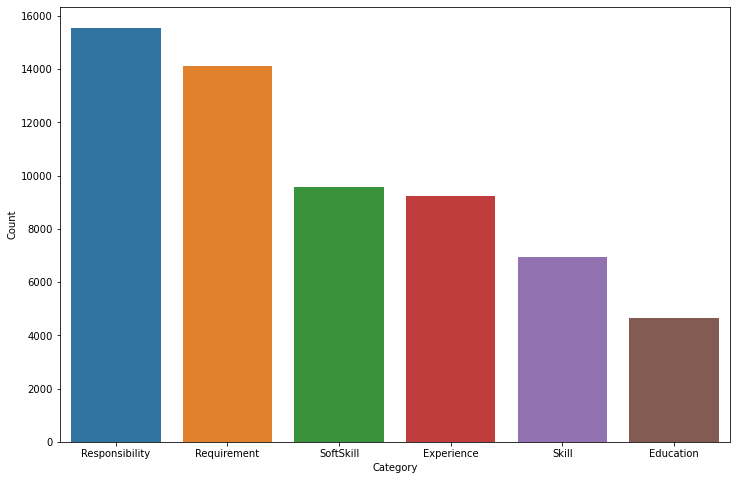

In [6]:
plt.figure(figsize=(12,8))
count = df.Type.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Category')
plt.ylabel('Count')

Splitting data into train validation test.

In [7]:
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [8]:
print("The length of train data is : ",len(train), "\nThe length of validate data is :",len(validate),"\nThe length of test data is : ",len(test))

The length of train data is :  45086 
The length of validate data is : 15029 
The length of test data is :  15029


In [9]:
train['Type'].value_counts()

Responsibility    9322
Requirement       8495
SoftSkill         5773
Experience        5494
Skill             4204
Education         2720
Name: Type, dtype: int64

Text(0, 0.5, 'Count')

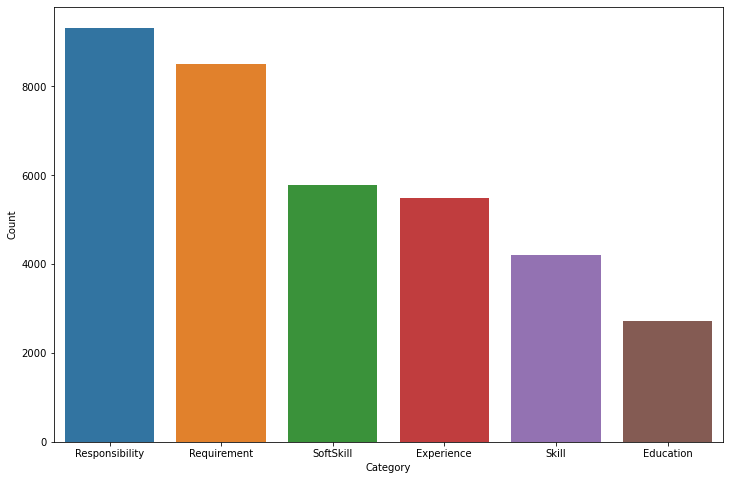

In [10]:
plt.figure(figsize=(12,8))
count = train.Type.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Category')
plt.ylabel('Count')

Counting the number of times, each word has appeared throughout the dataset by creating a dictionary for frequency count of words in the dataset.

In [11]:
import nltk
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')

REF https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

In [12]:
def word_counts(data_set) -> list:
    words_in_tuple = dict()
    text = data_set['New_Sentence']
    text = text.to_string()
    text = text.strip()
    text = text.lower()
    
    #words = [word for word in text.split(' ') if word not in sw_nltk]
    words = text.split(' ')
    #print(len(words))
    
    for word in words:
        if word == ' ' or word.isnumeric() == True:
            continue
        if word in words_in_tuple:
              words_in_tuple[word] = words_in_tuple[word] + 1
        else:
              words_in_tuple[word] = 1  
    for key in list(words_in_tuple.keys()):  ## creates a list of all keys
      if words_in_tuple[key] < 5:
        del words_in_tuple[key] 
       
    return (words_in_tuple)
vocab = word_counts(train)
print(len(vocab))

3291


In [13]:
#Conditional count of the words for every label 
# Refrenece blog : https://taherparatha.wordpress.com/portfolio/classifying-news-articles-using-naive-bayes-classifier-from-scratch/
import re
Types = df['Type'].unique()
def conditional_count_values(dataset,label):  
  word_count = {}
  for typ in Types:
    word_dict = {}
    data = df[df[label] == typ]['New_Sentence']
    for row in data:
      words = list(set(re.split("[^a-zA-Z]",str(row))))
      for word in words:
        word = word.lower()
        if word in word_dict:
          word_dict[word] = word_dict[word]+1
        else:
          word_dict[word] = 1
    for word, count in dict(word_dict).items():
      if (len(word)<3) or (count<=5):
        word_dict.pop(word)
    word_count[typ] = word_dict
  
  return pd.DataFrame(word_count).fillna(0)

temp = conditional_count_values(train,"Type")
print(temp)

             Responsibility  Requirement  Skill  SoftSkill  Education  \
design                924.0        404.0  315.0      158.0       93.0   
tech                   28.0         11.0    7.0        7.0       99.0   
quality               633.0        151.0   86.0       71.0       27.0   
development          1028.0        604.0  357.0      121.0       81.0   
other                 515.0        225.0  149.0       84.0      124.0   
...                     ...          ...    ...        ...        ...   
jaar                    0.0          0.0    0.0        0.0        0.0   
heavy                   0.0          0.0    0.0        0.0        0.0   
ado                     0.0          0.0    0.0        0.0        0.0   
poste                   0.0          0.0    0.0        0.0        0.0   
semi                    0.0          0.0    0.0        0.0        0.0   

             Experience  NaN  
design            479.0  0.0  
tech               41.0  0.0  
quality           161.0  0.0  

In [14]:
#returns the probability of the word with total number of docs.
def probability_of_word_in_all_documents(dataset,word_given,smoothing):
  return((word_counts(dataset)[word_given] + smoothing )/(len(dataset) + (len(dataset['Type'].unique()) * smoothing)))

In [15]:
#conditional probability value
def conditional_probability(dataset,word,category,smoothing):
  conditional_value_dataframe = conditional_count_values(train,'Type')
  probability_value = (conditional_value_dataframe.loc[word,category])*smoothing / ((conditional_value_dataframe[category].sum()) + (smoothing * len(conditional_value_dataframe[category])))
  return probability_value

In [16]:
def count_probability_class(category_set):
  result_probabilty = train.groupby('Type').size().div(len(train)) #count()['category']/len(category)
  return(result_probabilty)

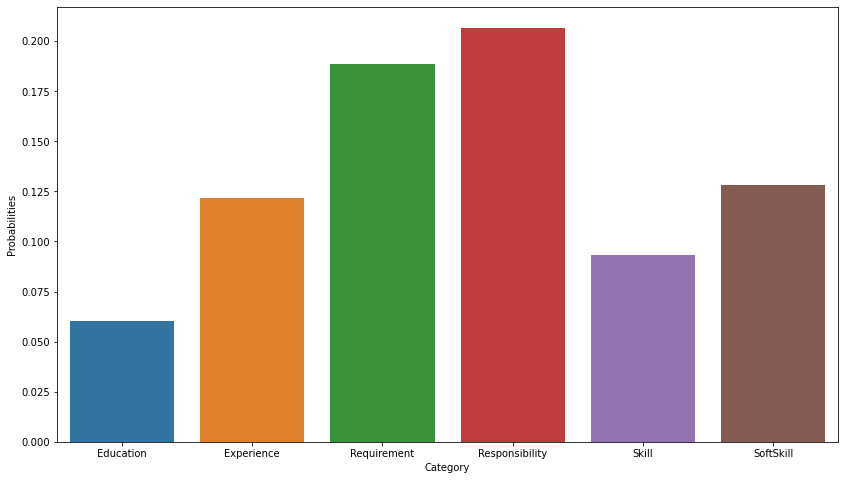

In [17]:
result_probabilty = train.groupby('Type').size().div(len(train)) #count()['category']/len(category)
plt.figure(figsize=(14,8))
sns.barplot(x=result_probabilty.index, y=result_probabilty)
plt.xlabel('Category')
plt.ylabel('Probabilities')
plt.show()

In [24]:
def nb_probability(word,data,category,smoothing):
  final_prob = conditional_probability(data,word,category,smoothing) * count_probability_class(train)
  print(final_prob[category])
  return final_prob[category]

# TRAINING THE DATASET.

In [25]:
vocab_train = word_counts(train)
cond_words_train = conditional_count_values(train,'Type')
cond_words_train.dropna()

,Responsibility,Requirement,Skill,SoftSkill,Education,Experience,NaN
design,924.0,404.0,315.0,158.0,93.0,479.0,0.0
tech,28.0,11.0,7.0,7.0,99.0,41.0,0.0
quality,633.0,151.0,86.0,71.0,27.0,161.0,0.0
development,1028.0,604.0,357.0,121.0,81.0,939.0,0.0
other,515.0,225.0,149.0,84.0,124.0,121.0,0.0
...,...,...,...,...,...,...,...
jaar,0.0,0.0,0.0,0.0,0.0,6.0,0.0
heavy,0.0,0.0,0.0,0.0,0.0,7.0,0.0
ado,0.0,0.0,0.0,0.0,0.0,6.0,0.0
poste,0.0,0.0,0.0,0.0,0.0,6.0,0.0


Finding the probability of the word “teams“.

In [26]:
probability_of_word_in_all_documents(train,"teams",1)  

0.00505621715122081

Finding the probability of the word “teams“ with different values of lapase smoothing parameter. 

In [27]:
print("When smoothing factor = 1 : ",conditional_probability(train,"teams",'Responsibility',1))
print("When smoothing factor = 0.1 : ",conditional_probability(train,"teams",'Responsibility',0.1))
print("When smoothing factor = 0.5 : ",conditional_probability(train,"teams",'Responsibility',0.5))

When smoothing factor = 1 :  0.0035428953175737463
When smoothing factor = 0.1 :  0.00036125069793411504
When smoothing factor = 0.5 :  0.0017906168356728513


Calculating the Naive Bayes probability of the word “the” across every category



In [30]:
class_train_probability = count_probability_class(train)
for i in train['Type'].unique():
  print(nb_probability("teams",train,i,0.1))

7.469234365749502e-05
7.469234365749502e-05
2.193571898814953e-05
2.193571898814953e-05


KeyError: nan